In [213]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import clear_output

In [214]:
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 3 )
plt.rc('lines', linewidth = 2)

plt.rc('lines', markersize = 3)

plt.rc('figure', figsize=(15,10) )         # Image size


import warnings
warnings.filterwarnings('ignore')

In [215]:
def setBoundary(sigma, val):# setting boundaries to the given values 
    
    sigma[0,:]  = val[0]
    sigma[-1,:] = val[1]
    sigma[:,0]  = val[2]
    sigma[:,-1] = val[3]
    return

In [216]:
def energy(sigma, J, H):
    ''' Calculate lattice Energy from Hamiltonian
        E = -J * sum(S(i)*S(j);i^j) - H * sum(S(j);j)
     Parameters
     ----------
     sigma : Full lattice that includ boundraries
     H : External field
     J : Interaction 
    '''
    return (-J * np.sum(sigma[:-1,:] * sigma[1:,:]) 
         + -J * np.sum(sigma[:,:-1] * sigma[:,1:]) 
         + - np.sum(H * sigma[1:-1,1:-1]))

In [217]:
def mcflip_sublat(sigma,a,b, J, H):
    """Update on sublattices defined by and randomly flip with probability
    set by the relative Gibbs weight."""
    
    # localH acts on the bulk sublattice which is defined by the slice
    # sigma[1+a:-1:2, 1+b:-1:2]
    Lx, Ly = sigma.shape
    localH = H[a::2, b::2] * sigma[1+a:-1:2, 1+b:-1:2] + J * sigma[1+a:-1:2, 1+b:-1:2]*(
            sigma[2+a:   :2, 1+b: -1:2] + # to the right
            sigma[  a: -2:2, 1+b: -1:2] + # to the left
            sigma[1+a: -1:2, 2+b:   :2] + # up
            sigma[1+a: -1:2,   b: -2:2]   # down 
            )
    
    #metropolis probability:
    p = np.exp(-2 * localH)
    sigma[1+a:-1:2, 1+b:-1:2] *= -1 * (2*(np.random.rand(Lx//2-1,Ly//2-1) < p) - 1)          
    return

In [218]:
#flips the spins and sets the periodic boundaries
def mcflip(sigma, J, H):
    mcflip_sublat(sigma,0,0, J, H)
    setBoundary(sigma,[sigma[-2,:],sigma[1,:],sigma[:,-2],sigma[:,1]])  
    mcflip_sublat(sigma,1,0, J, H)
    setBoundary(sigma,[sigma[-2,:],sigma[1,:],sigma[:,-2],sigma[:,1]])  
    mcflip_sublat(sigma,0,1, J, H)
    setBoundary(sigma,[sigma[-2,:],sigma[1,:],sigma[:,-2],sigma[:,1]])  
    mcflip_sublat(sigma,1,1, J, H)
    setBoundary(sigma,[sigma[-2,:],sigma[1,:],sigma[:,-2],sigma[:,1]])  
    return

In [219]:
def magnetization(sigma):
    return np.mean(sigma[1:-1,1:-1]) # exclude boundary spins

In [220]:
def runSample(nSteps = 10000, subSample = 10):
    """Run nSteps Monte Carlo sweeps on the 2D Ising model.
       Does not initialize the sample so can be called sequentially without
       reinitialization if desired.
   
       Returns:
           histMag -- array of magnetizations at every subSample timesteps
           histEn  -- array of energies at every subSample timesteps
   """
   
   # create lists to grow
    histMag = []
    histEn = []
        
    for t in range(nSteps):
        mcflip(sigma, J, H)   
        if t % subSample == 0:
            histMag.append(magnetization(sigma))
            histEn.append(energy(sigma, J, H))
    # return as arrays
    return (np.array(histMag), np.array(histEn))


In [221]:
def Generate(sigma,J,H):
    '''
    this function is the automatic data creator from our simulation
    it takes 6000 samples at first, dumps the first 2000 and then goes on with the method 
    explained in the report to sample efficiently and with good quality
    '''
    Mag0, En0= runSample(6000,1) 
    ac = acf(Mag0[2000:],length=900)
    step = corr_len(ac)
    Mag, En = Mag0[2000::step], En0[2000::step]
    if step is None:
        step=1
    print(step)
    if 1000//step < 100:
        Mag0, En0=runSample((500*step-1000),step)
        Mag = np.append(Mag,Mag0)
        En = np.append(En,En0)
     
   
    return(Mag, En, step)


In [222]:
def acf(x, length=20):
    ''' Auto Correlation Function'''
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])
def tp_corr(sigma,n,length=50):#two point correlation function 
    L=len(sigma)
    C=[]
    for i in range(1,length):
        Xi=[]
        Xj=[]
        for j in range(n):
            x=np.random.randint(0,L)
            y=np.random.randint(0,L)
            Xi+=[sigma[x][y]]
            Xj+=[sigma[x][(y+i)%L]]
        Xi=np.array(Xi)
        Xj=np.array(Xj)
        C+=[(np.mean(Xi*Xj)-np.mean(Xi)*np.mean(Xj))/np.var(Xi)]     
    return C
        

In [223]:
def corr_len(auto_corr):
    for i, ac in enumerate(auto_corr):
        if (np.abs(ac - (1/np.e)) <= 0.005) and (np.abs(ac - (1/np.e)) < np.abs(auto_corr[(i+1)%len(auto_corr)] - (1/np.e))):
            return i

In [224]:
Jcrit = np.log(1+np.sqrt(2.))/2 # J in Critical temperature

In [225]:
listt=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4, 1.6, 1.8]
lx, ly = 100, 100
h = 0.3                  

In [226]:
Mlist_hgauss=[]
Elist_hgauss=[]
Xilist_hgauss=[]                           
Cvlist_hgauss = []
logzlist_hgauss = []
zlist_hgauss = []

SH = 0.3#standard deviation for gaussian random field
H_gauss = np.random.normal(h, SH, size = (lx, ly))
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])                           
for a in listt: 
    J = a*Jcrit #Interaction
    H = H_gauss
    M, E, Step = Generate(sigma,J,H) #, Ksi, Step = Generate(sigma,J,H)
    Mlist_hgauss+=[np.mean(M)]
    Xilist_hgauss+=[np.var(M)]
    Elist_hgauss+=[np.mean(E)]
    Cvlist_hgauss+=[np.var(E)]
    logzlist_hgauss+=[np.mean(-J * E)]               
    zlist_hgauss+=[np.mean(np.exp(-J * E))]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [227]:
Mlist_hconst=[]
Elist_hconst=[]
Xilist_hconst=[]
Cvlist_hconst = []
logzlist_hconst =[]
zlist_hconst = []


sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
H_const = np.zeros((lx,ly)) + h #External field
for a in listt:
    J = a*Jcrit #Interaction
    # make the initial 'full lattice'
    H = H_const
    M, E, Step = Generate(sigma,J,H) #, Ksi, Step = Generate(sigma,J,H)
    Mlist_hconst+=[np.mean(M)]
    Xilist_hconst+=[np.var(M)]
    Elist_hconst+=[np.mean(E)]
    Cvlist_hconst+=[np.var(E)]
    logzlist_hconst+=[np.mean(-J * E)] 
    zlist_hconst+=[np.mean(np.exp(-J * E))]


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [228]:
Mlist_hzero=[]
Elist_hzero =[]
Xilist_hzero=[]
Cvlist_hzero = [] 
logzlist_hzero = []
zlist_hzero = []

H_zero = np.zeros((lx,ly)) #External field
sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])                           
for a in listt:
    J = a*Jcrit #Interaction
    H = H_zero
    M, E, Step = Generate(sigma,J,H) #, Ksi, Step = Generate(sigma,J,H)
    Mlist_hzero+=[np.mean(M)]
    Xilist_hzero+=[np.var(M)]
    Elist_hzero+=[np.mean(E)]
    Cvlist_hzero+=[np.var(E)]
    logzlist_hzero+=[np.mean(-J * E)]                        
    zlist_hzero+=[np.mean(np.exp(-J * E))]

1
1
1
1
1
1
1
1
1
18
246
1
1
1
1
1
1


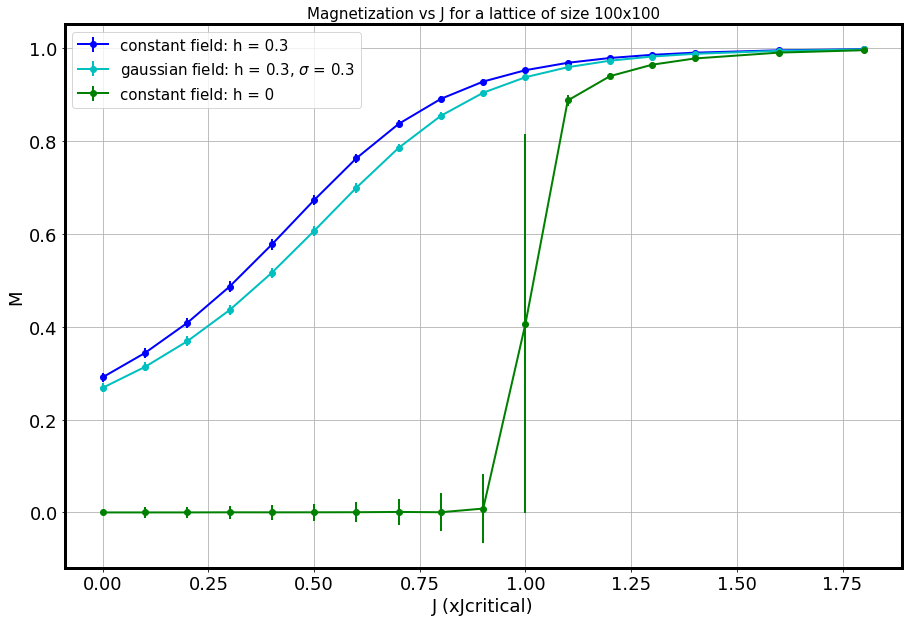

In [229]:
fig, ax = plt.subplots()
plt.xlabel("J (xJcritical)")
plt.ylabel("M")
plt.title("Magnetization vs J for a lattice of size 100x100")
plt.errorbar(listt,np.abs(Mlist_hconst), yerr = np.sqrt(Xilist_hconst), fmt = '.b-', markersize=12, label = 'constant field: h = {}'.format(h))
plt.errorbar(listt,np.abs(Mlist_hgauss), yerr = np.sqrt(Xilist_hgauss), fmt = '.c-', markersize=12, label = 'gaussian field: h = {}, $\sigma$ = {}'.format(h, SH))
plt.errorbar(listt,np.abs(Mlist_hzero), yerr = np.sqrt(Xilist_hzero), fmt = '.g-', markersize=12, label = 'constant field: h = 0')
#plt.plot(listt,np.abs(Mlist), 'b-', fmt = 'o')
ax.tick_params(labelsize=18)
ax.legend()
ax.grid(True)

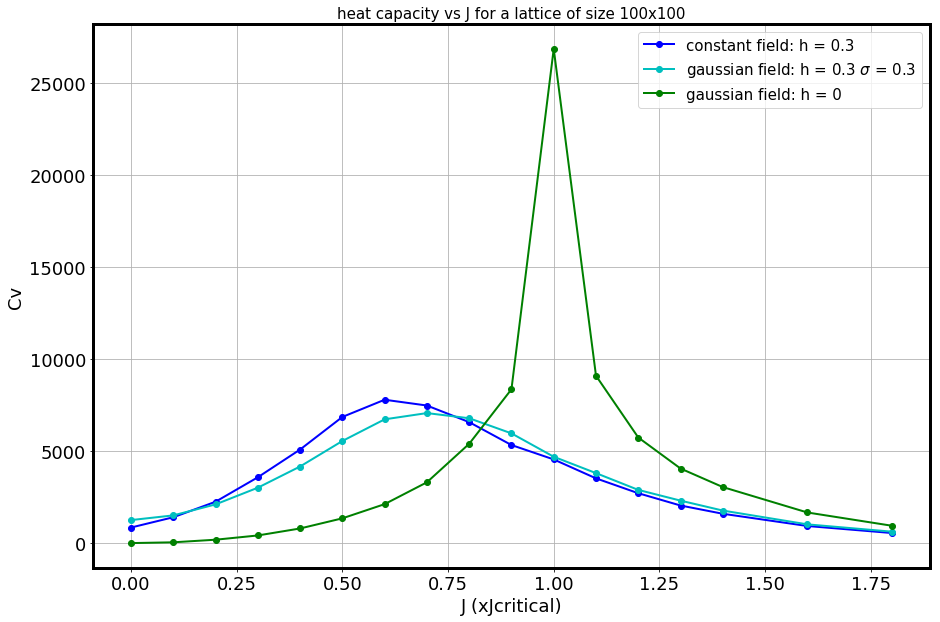

In [230]:
#Cv for all fields
fig, ax = plt.subplots()
plt.xlabel("J (xJcritical)")
plt.ylabel("Cv")
plt.title("heat capacity vs J for a lattice of size 100x100")
plt.errorbar(listt,Cvlist_hconst, fmt = '.b-', markersize=12, label = 'constant field: h = {}'.format(h))
plt.errorbar(listt,Cvlist_hgauss, fmt = '.c-', markersize=12, label = 'gaussian field: h = {} $\sigma$ = {}'.format(h, SH))
plt.errorbar(listt,Cvlist_hzero, fmt = '.g-', markersize=12, label = 'gaussian field: h = 0')

ax.tick_params(labelsize=18)
ax.legend()
ax.grid(True)


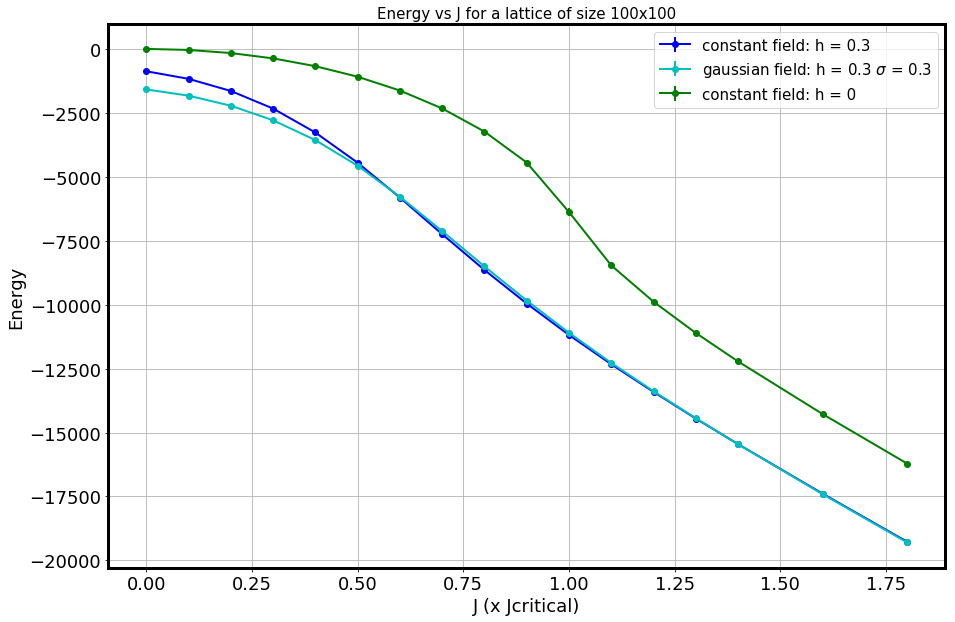

In [19]:
#Energy for all fields
fig, ax = plt.subplots()
plt.xlabel("J (x Jcritical)")
plt.ylabel("Energy")
plt.title("Energy vs J for a lattice of size 100x100")

plt.errorbar(listt,Elist_hconst, yerr=np.sqrt(Cvlist_hconst), fmt = '.b-', markersize=12, label = 'constant field: h = {}'.format(h))
plt.errorbar(listt,Elist_hgauss, yerr=np.sqrt(Cvlist_hgauss),fmt = '.c-', markersize=12, label = 'gaussian field: h = {} $\sigma$ = {}'.format(h, SH))
plt.errorbar(listt,Elist_hzero, yerr=np.sqrt(Cvlist_hzero),fmt = '.g-', markersize=12, label = 'constant field: h = 0')

ax.tick_params(labelsize=18)
ax.legend()
ax.grid(True)

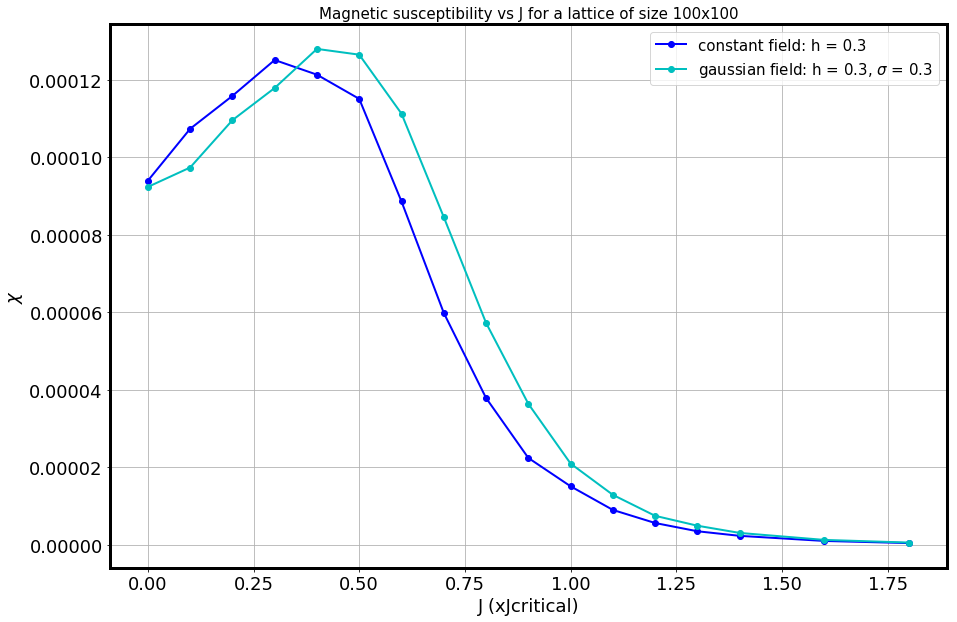

In [241]:
#chi for all
fig, ax = plt.subplots()
plt.xlabel("J (xJcritical)")
plt.ylabel("$\chi$")
plt.title("Magnetic susceptibility vs J for a lattice of size 100x100")
plt.errorbar(listt,Xilist_hconst, fmt = '.b-', markersize=12, label = 'constant field: h = {}'.format(h))
plt.errorbar(listt,Xilist_hgauss, fmt = '.c-', markersize=12, label = 'gaussian field: h = {}, $\sigma$ = {}'.format(h, SH))
nplistt = np.array(listt)
y = (1 - 1/(2 * nplistt))
#plt.plot(nplistt, y)
#plt.errorbar(listt,Xilist_hzero, fmt = '.g-', markersize=12, label = 'constant field: h = 0')
#plt.plot(listt,np.abs(Mlist), 'b-', fmt = 'o')
ax.tick_params(labelsize=18)
ax.legend()
ax.grid(True)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

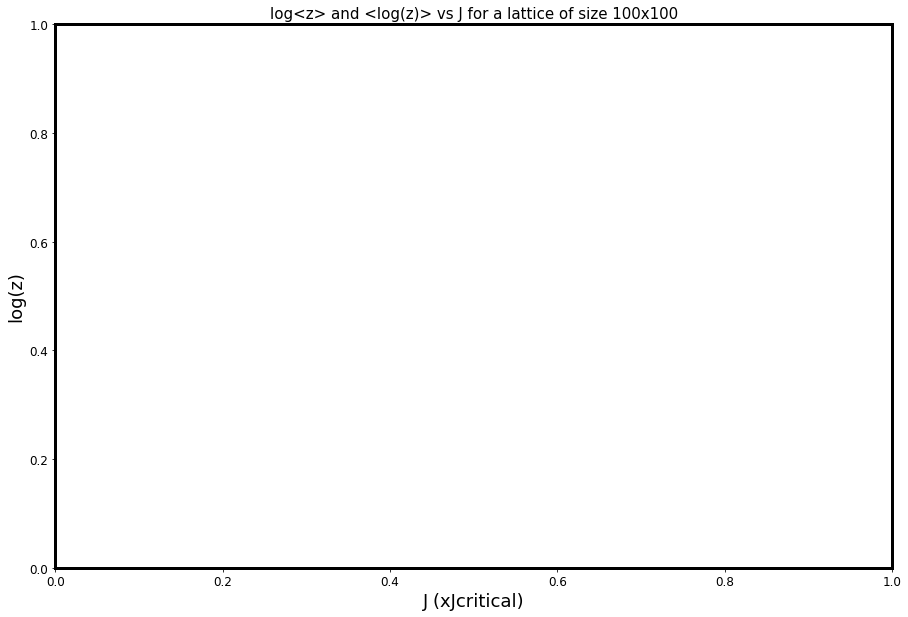

In [212]:
#chi for all
fig, ax = plt.subplots()
plt.xlabel("J (xJcritical)")
plt.ylabel("log(z)")
plt.title("log<z> and <log(z)> vs J for a lattice of size 100x100")
plt.errorbar(listt[:7],np.log(zlist_hconst[:7]), fmt = '.b-', markersize=12, label = 'log<z>, h = {}'.format(h))
plt.errorbar(listt[:7],np.log(zlist_hgauss[:7]), fmt = '.c-', markersize=12, label = 'log<z>, h = {}, $\sigma$ = {}'.format(h, SH))
plt.errorbar(listt[:7],np.log(zlist_hzero[:7]), fmt = '.g-', markersize=12, label = 'log<z>, h = 0')
plt.errorbar(listt[:7],logzlist_hconst[:7], fmt = '.b--', markersize=12, label = '<logz>, h = {}'.format(h))
plt.errorbar(listt[:7],logzlist_hgauss[:7], fmt = '.c--', markersize=12, label = '<logz>, h = {}, $\sigma$ = {}'.format(h, SH))
plt.errorbar(listt[:7],logzlist_hzero[:7], fmt = '.g--', markersize=12, label = '<logz>, h = 0')

ax.tick_params(labelsize=18)
ax.legend()
ax.grid(True)

In [97]:
listt=[0.3, 0, 0.7]
hlist=np.linspace(-2,-0.5,5)
hlist = np.append(hlist, np.linspace(-0.4,0.4,8))
hlist = np.append(hlist, np.linspace(0.5,2,5))

lx, ly = 100, 100
Mlist_vs_hconst = []
Mlist_err_hconst = []

for h in hlist:
    sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
    H = np.zeros((lx,ly)) + h #External constant field
    for a in listt:
        J = a*Jcrit #Interaction
        # make the initial 'full lattice'
        M, E, Step = Generate(sigma,J,H)#, Ksi, Step = Generate(sigma,J,H)
        Mlist_vs_hconst+=[np.mean(M)]
        Mlist_err_hconst+=[np.var(M)]


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [74]:
listt=[0.3, 0, 0.7]
hlist=np.linspace(-2,-0.5,5)
hlist = np.append(hlist, np.linspace(-0.4,0.4,8))
hlist = np.append(hlist, np.linspace(0.5,2,5))
SH = 0.3

lx, ly = 100, 100
Mlist_vs_hgauss = []
Mlist_err_hgauss = []


for h in hlist:
    H = np.random.normal(h, SH, size = (lx, ly)) #External constant field
    sigma = np.random.choice([-1,1],size=(lx+2,ly+2),p=[0.5,0.5])
    for a in listt:
        J = a*Jcrit #Interaction
        # make the initial 'full lattice'
        M, E, Step = Generate(sigma,J,H)#, Ksi, Step = Generate(sigma,J,H)
        Mlist_vs_hgauss+=[np.mean(M)]
        Mlist_err_hgauss += [np.var(M)]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


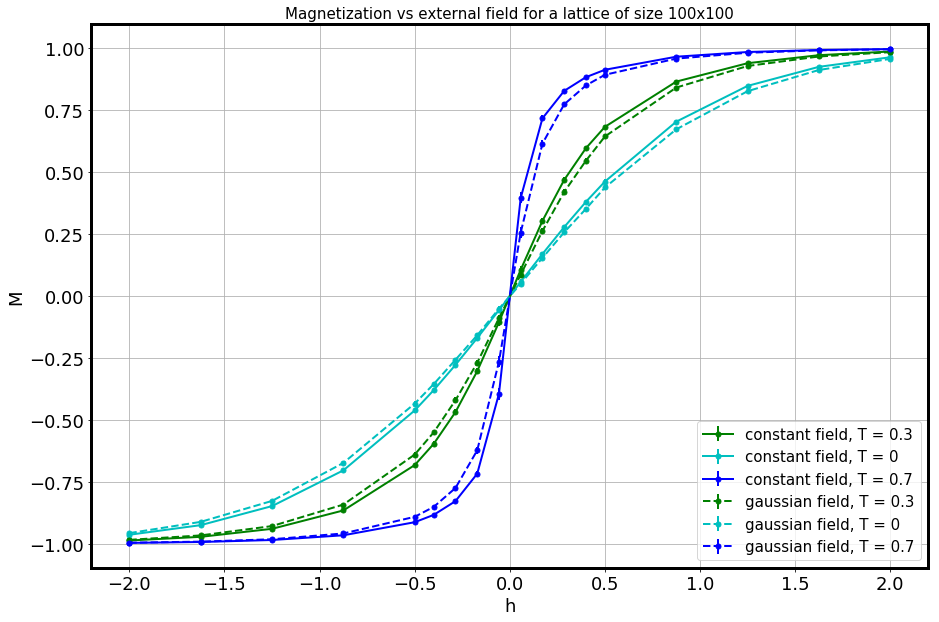

In [210]:
Mlist_vs_hconst=np.array(Mlist_vs_hconst)
Mlist_vs_hgauss=np.array(Mlist_vs_hgauss)
Mlist_err_hconst=np.array(Mlist_err_hconst)
Mlist_err_hgauss=np.array(Mlist_err_hgauss)

fig, ax = plt.subplots()

plt.xlabel("h")
plt.ylabel("M")
plt.title("Magnetization vs external field for a lattice of size 100x100")

lines = []
lines2 = []
labels = []
labels2= []

lines += ax.errorbar(hlist, Mlist_vs_hconst[0::3],  yerr = np.sqrt(Mlist_err_hconst[0::3]), fmt = '.g-', ms = 10, label = 'constant field, T = {}'.format(listt[0]))
lines += ax.errorbar(hlist, Mlist_vs_hconst[1::3],  yerr = np.sqrt(Mlist_err_hconst[1::3]), fmt = '.c-', ms = 10, label = 'constant field, T = {}'.format(listt[1]))
lines += ax.errorbar(hlist, Mlist_vs_hconst[2::3],  yerr = np.sqrt(Mlist_err_hconst[2::3]), fmt = '.b-', ms = 10, label = 'constant field, T = {}'.format(listt[2]))

lines2 += ax.errorbar(hlist, Mlist_vs_hgauss[0::3] , yerr = np.sqrt(Mlist_err_hgauss[0::3]), fmt = '.g--', ms = 10, label = 'gaussian field, T = {}'.format(listt[0]))
lines2 += ax.errorbar(hlist, Mlist_vs_hgauss[1::3] , yerr = np.sqrt(Mlist_err_hgauss[1::3]), fmt = '.c--', ms = 10, label = 'gaussian field, T = {}'.format(listt[1]))
lines2 += ax.errorbar(hlist, Mlist_vs_hgauss[2::3] , yerr = np.sqrt(Mlist_err_hgauss[2::3]), fmt = '.b--', ms = 10, label = 'gaussian field, T = {}'.format(listt[2]))

ax.legend(loc = 'lower right')
ax.tick_params(labelsize=18)
ax.grid(True)
